---
title: Monotonic Networks
subtitle: Neural Networks as Activation Functions
date: 2025/01/26
bibliography:
  - monotonic_networks_references.bib
---

In [1]:
# Basic imports
import torch
from torch import nn

from assets.shapes import square, circle, stanford_bunny
from assets.loss_functions import mse
from assets.utils import automate_training, plot_curves

# Creating Injective Functions with Parameters

We observed earlier that with the [`PReLU`](#parameter_insight) activation Injective Networks
perform much better. Therefore, the insight we gain that will help us power up Injective Networks is
: **add more parameters**.

One way to add parameters to the Network is to use parameterized activation functions e.g.
$\sigma(\beta x)$ i.e. the sigmoid with a parameter $\beta$ or try and create other activations.
During the creation of these parameterized activations one needs to keep in mind that injectivity
should not be violated for any parameter value to ensure that the network always represents only
simple closed curves, which is our final goal.

It is quite difficult to combine activation functions together with appropriate parameters that add
representation power while maintaining injectivity. We will therefore look at a much more drastic
and interesting approach.

First, we need to understand how we could create a function that is injective. The first step is to
realize that:
> A continuous function is injective if and only if it is strictly monotonic.[^injective_monotonic]

Therefore we can create injective functions by creating strictly monotonic functions.

[^injective_monotonic]: Math StackExchange,
    [Continuous injective map is strictly monotonic](https://math.stackexchange.com/questions/752073/continuous-injective-map-is-strictly-monotonic)

# Monotonic Networks: A Superpower

We will create injective activation functions using a drastic measure. Every activation function
will be an injective neural network!

We will create neural networks that take in a scalar input and output a scalar value and are
strictly monotonic in the input. Mathematically our activation function now is a neural network $M$
$$
M: \mathbb{R} \rightarrow \mathbb{R}
$$
which satisfies one of:
$$
M(x_1) < M(x_2) \quad \forall x_1, x_2 \in \mathbb{R} \quad s.t. \; x_1 < x_2\\
M(x_1) > M(x_2) \quad \forall x_1, x_2 \in \mathbb{R} \quad s.t. \; x_1 > x_2
$$

:::{card}
:header: Monotonic Networks
:footer: [@sill1997monotonic; @igel2023smooth; @wehenkel2019unconstrained; @kitouni2023expressive; @runje2023constrained]
We will choose neural networks that _by design_ for _any_ parameter value are always monotonic,
these are called **_Monotonic Networks_**.
:::

Every activation layer will be an independent Monotonic Network and all neurons will use the same
neural network. This is shown in [](#neural_injective_geometry_net).
:::{figure} assets/neural_injective_geometry_net
:label: neural_injective_geometry_net
:alt: Injective Networks with Monotonic Networks as activation functions
:height: 210px
Injective Network with Monotonic Networks as activation functions. $M_1$ shown in the figure is a
monotonic network.
:::

## Building Monotonic Networks with Smooth Min-Max Networks
Building Monotonic Networks is an active area of research and there are a few popular choices. The
first Monotonic Network was designed by @sill1997monotonic which used $min$ and $max$ operations to
impart monotonicity. But since the $min-max$ operations are not differentiable they are hard
to train and also suffer from dead neurons[^dead_neurons]. Recently @igel2023smooth proposed a
variation of the original Monotonic Networks proposed by @sill1997monotonic, which replaces the hard
$min-max$ with their smooth variants. These are called Smooth Min-Max Monotonic Networks.

We will use Smooth Min-Max Monotonic Networks as activation functions to augment Injective Networks.
We use the code provided in Christian's Repository
[https://github.com/christian-igel/SMM](https://github.com/christian-igel/SMM).

[^dead_neurons]: Data Science StackExchange
    [What is the "dying ReLU" problem in neural networks?](https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks)

In [2]:
import numpy as np
from assets.SmoothMonotonicNN import SmoothMonotonicNN

class NIG_Net(nn.Module):
    def __init__(self, layer_count_inj, smm_num_grps, smm_neurons_per_grp):
        super().__init__()

        # Transformation from t on the [0, 1] interval to unit circle for closed shapes
        self.closed_transform = lambda t: torch.hstack([
            torch.cos(2 * torch.pi * t),
            torch.sin(2 * torch.pi * t)
        ])

        self.layer_count_inj = layer_count_inj
        self.linear_layers = nn.ModuleList()
        self.monotonic_act = nn.ModuleList()

        for i in range(layer_count_inj):
            self.linear_layers.append(nn.Linear(2, 2))
            self.monotonic_act.append(SmoothMonotonicNN(
                n = 1, K = smm_num_grps, h_K = smm_neurons_per_grp, mask = np.array([1])
            ))
        
    def forward(self, t):
        x = self.closed_transform(t)

        for linear_layer, monotonic_act in zip(self.linear_layers, self.monotonic_act):
            # Apply linear transformation
            x = linear_layer(x)
            # Apply monotonic layers to each component of x separately
            x1, x2 = x[:, 0:1], x[:, 1:2]  # Efficient slicing
            x = torch.stack([monotonic_act(x1), monotonic_act(x2)], dim = -1)

        return x

Epoch: [    1/10000]. Loss:    0.000368
Epoch: [ 2000/10000]. Loss:    0.000347
Epoch: [ 4000/10000]. Loss:    0.000321
Epoch: [ 6000/10000]. Loss:    0.000301
Epoch: [ 8000/10000]. Loss:    0.000288
Epoch: [10000/10000]. Loss:    0.000279


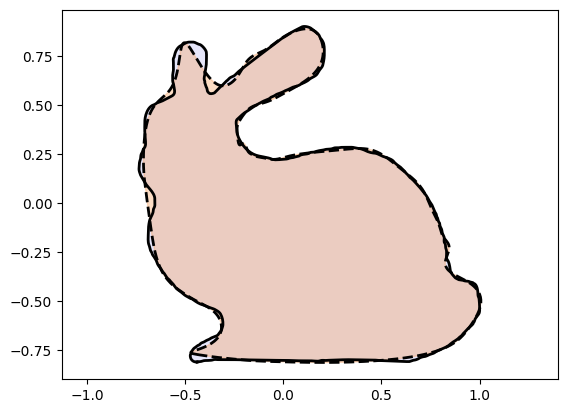

In [22]:
# Generate target curve points
X_t_bunny = stanford_bunny(num_points = 1000)
num_pts = X_t_bunny.shape[0]
t = torch.linspace(0, 1, num_pts).reshape(-1, 1)

bunny_net = NIG_Net(
    layer_count_inj = 8, smm_num_grps = 8, smm_neurons_per_grp = 8
)
automate_training(
    model = bunny_net, loss_fn = mse, X_train = t, Y_train = X_t_bunny,
    learning_rate = 0.001, epochs = 10000, print_cost_every = 2000
)

X_p_bunny = bunny_net(t)
plot_curves(X_p_bunny, X_t_bunny)

We observe an amazing improvement! Using Monotonic Networks as activation functions bolsters
Injective Networks by introducing a lot of parameters which can be tuned to fit shapes with high
accuracy.